# Surprising Pairs
**Find the pairs which appear to be the most non-linear in the pair-dataset.**

One complication: the set of notes for individual molecules is different from the notes of blend molecules. 

In [1]:
import json

# Load the dataset
with open("data/full.json") as f:
    dataset = json.load(f)
len(dataset), dataset[0]

(166814,
 {'mol1': 'CCCCC/C=C/C(=O)OC',
  'mol1_notes': ['violet',
   'sweet',
   'oily',
   'melon',
   'pear',
   'hairy',
   'costus',
   'fruity',
   'violet leaf',
   'waxy',
   'fresh',
   'green'],
  'mol2': 'CCCCCOC(=O)CCC',
  'mol2_notes': ['cherry',
   'sweet',
   'pineapple',
   'fruity',
   'banana',
   'tropical'],
  'blend_notes': ['animal', 'fruity', 'waxy']})

**Let's filter for short blends**

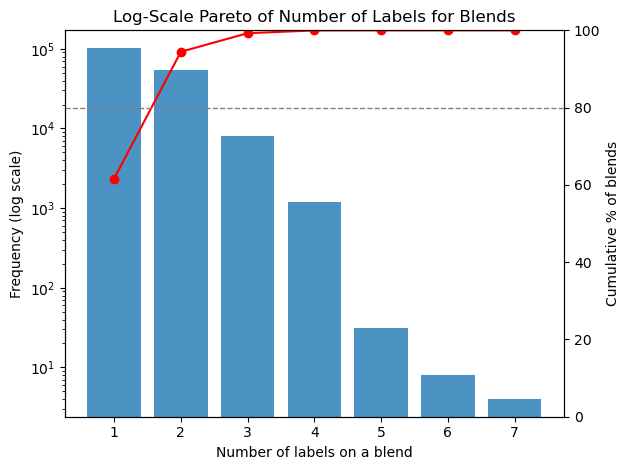

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- original data ---
lengths = [len(d["blend_notes"]) for d in dataset]

# --- build the Pareto data ---
counts = np.bincount(lengths)
x_vals = np.arange(len(counts))

nonzero = counts > 0          # drop zero-count bins
x_vals  = x_vals[nonzero]
counts  = counts[nonzero]

order   = np.argsort(counts)[::-1]
x_sorted      = x_vals[order]
counts_sorted = counts[order]
cum_pct = np.cumsum(counts_sorted) / counts_sorted.sum() * 100

# --- plot ---
fig, ax1 = plt.subplots()

bars = ax1.bar(x_sorted, counts_sorted, alpha=0.8)
ax1.set_yscale('log')              # ← the only new line
ax1.set_xlabel("Number of labels on a blend")
ax1.set_ylabel("Frequency (log scale)")

ax2 = ax1.twinx()
ax2.plot(x_sorted, cum_pct, color="r", marker="o")
ax2.set_ylabel("Cumulative % of blends")
ax2.set_ylim(0, 100)
ax2.axhline(80, ls="--", lw=1, color="grey")

plt.title("Log-Scale Pareto of Number of Labels for Blends")
plt.tight_layout()
plt.show()

In [3]:
MIN_LENGTH = 3

dataset = [d for d in dataset if len(d["blend_notes"]) >= MIN_LENGTH]
len(dataset), dataset[0]

(9258,
 {'mol1': 'CCCCC/C=C/C(=O)OC',
  'mol1_notes': ['violet',
   'sweet',
   'oily',
   'melon',
   'pear',
   'hairy',
   'costus',
   'fruity',
   'violet leaf',
   'waxy',
   'fresh',
   'green'],
  'mol2': 'CCCCCOC(=O)CCC',
  'mol2_notes': ['cherry',
   'sweet',
   'pineapple',
   'fruity',
   'banana',
   'tropical'],
  'blend_notes': ['animal', 'fruity', 'waxy']})

**Find the set of all notes and encode instances using one hot.**

In [4]:
import numpy as np

all_blend_notes = set()
all_single_notes = set()

for d in dataset:
    all_blend_notes.update(d["blend_notes"])
    all_single_notes.update(d["mol1_notes"])
    all_single_notes.update(d["mol2_notes"])

all_blend_notes = np.array(list(all_blend_notes))
all_single_notes = np.array(list(all_single_notes))
len(all_blend_notes), len(all_single_notes)

(102, 454)

In [5]:
def one_hot(notes,all_notes):
    encode = np.zeros(len(all_notes))
    for n in notes:
        encode[all_notes.index(n)] = 1
    return encode

one_hot(dataset[0]["blend_notes"], all_blend_notes.tolist())

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [6]:
from tqdm.notebook import tqdm

X = []
y = []

# Using sum for single notes b/c that is more expressive.
for d in tqdm(dataset):
    X.append(one_hot(d["mol1_notes"], all_single_notes.tolist()) + one_hot(d["mol2_notes"], all_single_notes.tolist()))
    y.append(one_hot(d["blend_notes"], all_blend_notes.tolist()))

X = np.stack(X)
y = np.stack(y)

X.shape, y.shape

  0%|          | 0/9258 [00:00<?, ?it/s]

((9258, 454), (9258, 102))

**Build logistic regression models to predict blend notes from single notes**

In [7]:
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier

models = []
for idx in tqdm(range(y.shape[1])):
    models.append(LogisticRegression(class_weight="balanced",max_iter=1000).fit(X,y[:,idx]))
len(models), models[0]

  0%|          | 0/102 [00:00<?, ?it/s]

(102, LogisticRegression(class_weight='balanced', max_iter=1000))

**Calculate predictions and probability of label**

In [8]:
prob = np.stack([model.predict_proba(X) for model in tqdm(models)],axis=-1)
# Get probability for positive label
prob = prob[:,1,:]

pred = np.stack([model.predict(X) for model in tqdm(models)],axis=-1)
pred.shape, prob.shape

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

((9258, 102), (9258, 102))

**Calculate log-likelihood**

In [10]:
from scipy import sparse
# ---------- choose a loss / residual ----------
eps = 1e-12                               # numerical safety

# y is sparse
y_dense   = y
logloss_each = -np.sum(
        y_dense * np.log(prob + eps) +
        (1 - y_dense) * np.log(1 - prob + eps),
        axis=1)                           # shape (n_samples,)
logloss_each.shape

(9258,)

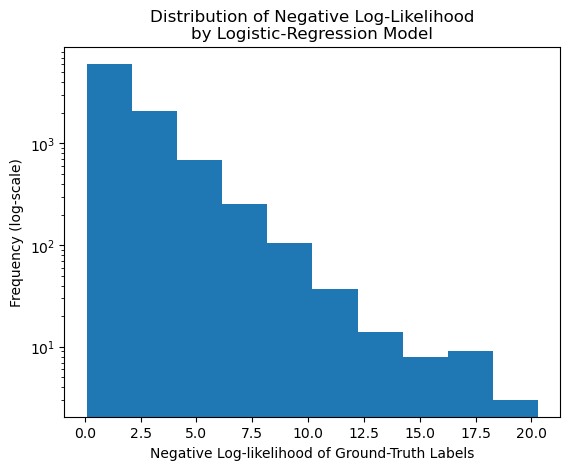

In [13]:
# plt.hist(np.exp(-logloss_each))
plt.hist(logloss_each)
plt.title("Distribution of Negative Log-Likelihood\nby Logistic-Regression Model")

plt.yscale("log")

plt.xlabel("Negative Log-likelihood of Ground-Truth Labels")
plt.ylabel("Frequency (log-scale)")

plt.show()

**Sort by least-likely and generate output**

In [14]:
import copy

sorted_indices = np.argsort(-logloss_each)
top_k = 100
output_dataset = []

for idx in sorted_indices[:top_k]:
    output = copy.deepcopy(dataset[idx])
    
    # Put predictions into the output entry
    output["pred_blend"] = all_blend_notes[np.where(pred[idx]==1)].tolist()
    output["log-likelihood"] = logloss_each[idx]
    
    # Sort both lists for clarity
    output["blend_notes"] = sorted(output["blend_notes"])
    output["pred_blend"] = sorted(output["pred_blend"])
    
    output_dataset.append(output)

len(output_dataset), output_dataset[0]

(100,
 {'mol1': 'C1=CNC=C1',
  'mol1_notes': ['nutty', 'ethereal', 'warm', 'sweet'],
  'mol2': 'CCCCCCO',
  'mol2_notes': ['sweet',
   'oily',
   'green',
   'alcoholic',
   'pungent',
   'fruity',
   'fusel',
   'ethereal'],
  'blend_notes': ['alcoholic', 'green', 'herbal'],
  'pred_blend': ['alcoholic',
   'ethereal',
   'fruity',
   'green',
   'herbal',
   'nutty',
   'winey'],
  'log-likelihood': 20.290376694418793})

In [ ]:
with open("Output/unlikely_pairs.json","w") as f:
    json.dump(output_dataset,f)

**One possible next step is to use the pair labels from the larger dataset, and the single labels from here**